In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import glob
from scipy.optimize import curve_fit
from astropy import coordinates
from astropy import units as u

In [4]:
figsize(10, 8)

In [5]:
banks = ['A', 'B', 'C']

In [6]:
def line(x, m, b):
    return m * x + b

In [9]:
def naive_map(data,ra,dec):
    ra_bins = np.linspace(105.754, 108.639, 172)
    dec_bins = np.linspace(3.731, 6.67, 172)
    p,_,_ = np.histogram2d(ra, dec, bins=(ra_bins, dec_bins), weights=data)
    hits,_,_ = np.histogram2d(ra, dec, bins=(ra_bins, dec_bins))
    return p.T, hits.T, ra_bins, dec_bins

In [31]:
def get_map(bank='A', session='5', doplot=False, pixbeam=1., smth=0, removeplane=False):
    dataf = np.load('/home/mabitbol/GBT-S140/datamaps/tod'+bank+'_'+session+'.npz')
    tmask = dataf['tmask']
    ras = dataf['ras'][tmask]
    decs = dataf['decs'][tmask]
    calibrated = dataf['calibrated'][tmask]
    
    tmask2 = ~np.isnan(calibrated)
    ras = ras[tmask2]
    decs = decs[tmask2]
    calibrated = calibrated[tmask2] 
    
    c = coordinates.SkyCoord(frame='fk5', ra=ras*u.degree, dec=decs*u.degree)
    decs = c.galactic.b.deg
    ras = c.galactic.l.deg
    rc = 107.2
    dc = 5.2
    
    if bank == 'A':
        cfreq = 4.575
    elif bank == 'B':
        cfreq = 5.625
    elif bank == 'C':
        cfreq = 6.125
    elif bank == 'D':
        cfreq = 7.175
    beam = 12.6 / cfreq
    
    # units
    # beam and pixbeam are in arcminutes
    beamarea = np.pi / (4. * np.log(2)) * beam**2
    pixelarea = pixbeam**2
    units = pixelarea / beamarea
    units = 1.
    
    # ras and decs are in degrees 
    nrapix = int((ras.max() - ras.min()) / (pixbeam / 60.))
    ndecpix = int((decs.max() - decs.min()) / (pixbeam / 60.))
    
    datamap, hits, rabins, decbins = naive_map(calibrated, ras, decs) 
    mask = hits == 0
    signal = np.zeros_like(datamap)
    signal[~mask] = datamap[~mask] / hits[~mask] * units
    
    radius = np.sqrt( (ras-rc)**2 + (decs-dc)**2)
    
    rmask = radius <= 1.
    insidedata = np.zeros_like(calibrated)
    insidedata[rmask] = 10.
    innermap, innerhits, rabins, decbins = naive_map(insidedata, ras, decs) 
    innerregion = innermap > 0
    
    annulus = (radius >= 80./60.) & (radius <= 2.)
    outerdata = np.zeros_like(calibrated)
    outerdata[annulus] = 10.
    outermap, outerhits, rabins, decbins = naive_map(outerdata, ras, decs)
    outerregion = outermap > 0

    rabinsc = (rabins[1:] + rabins[:-1]) / 2.
    decbinsc = (decbins[1:] + decbins[:-1]) / 2.
    if removeplane:
        X, Y = np.meshgrid(rabinsc, decbinsc)
        XX = X.flatten()
        YY = Y.flatten()
        Z = signal.flatten()
        masks = ~np.isnan(Z) * ~innerregion.flatten()
        data = np.c_[XX[masks], YY[masks], Z[masks]]
        data2 = np.c_[XX, YY, Z]
        A = np.c_[data[:, 0], data[:, 1], np.ones(data.shape[0])]
        C, _, _, _ = linalg.lstsq(A, data[:, 2])
        res = C[0] * X + C[1] * Y + C[2]
        signal -= res
        
    signal -= np.nanmedian(signal[outerregion])
    if smth is None:
        smth = beam
    if smth > 0:
        sigma = smth / pixbeam / (2. * np.sqrt(2. * np.log(2)))
        signal = gaussian_filter(signal, sigma)
        shits = gaussian_filter(hits, sigma)
        mask = shits < 1
    signal[mask] = np.nan
    
    if doplot:
        figure()
        pc = pcolormesh(rabinsc, decbinsc, signal * 1000.)
        clim(-10, 10)
        cb = colorbar()
        xlabel('$\mathrm{Lon}\ (deg)$')
        ylabel('$\mathrm{Lat}\ (deg)$')
        cb.set_label('$\mathrm{Flux}\ (mJy / pixel)$')
        #savefig('s4map_bank'+bank+'session'+session)
    
    print np.nansum(signal[innerregion]), np.nanstd(signal[outerregion]) * np.sqrt(innerregion.sum())
    return signal, rabins, decbins

In [32]:
def compare_pixels(map1, map2):
    N = size(map1)
    sigA = map1.reshape(N, -1)
    sigB = map2.reshape(N, -1)
    maskA = ~np.isnan(sigA)
    maskB = ~np.isnan(sigB)
    mask = maskA * maskB
    popt = curve_fit(line, sigA[mask], sigB[mask])
    print popt[0]
    
    figure()
    plot(sigA, sigB, '.')
    plot(sigA, line(sigA, 1., 0), 'g')
    plot(sigA, line(sigA, *popt[0]), 'k')
    plot(popt[0][1],popt[0][1], 'rx', markersize=10)
    grid()

In [33]:
def difference_map(map1, map2, ms=False):
    maskA = ~np.isnan(map1)
    maskB = ~np.isnan(map2)
    mask = maskA * maskB
    diffAB = map1 - map2
    diffAB[~mask] = np.nan
    
    if ms:
        diffAB -= np.nanmean(diffAB)
    
    figure()
    pc = pcolormesh(rabins, decbins, diffAB)
    clim(-.05, .05)
    cb = colorbar()
    xlabel('RA [degrees]')
    ylabel('DEC [degrees]')

In [34]:
def perdifference_map(map1, map2):
    maskA = ~np.isnan(map1)
    maskB = ~np.isnan(map2)
    mask = maskA * maskB
    diffAB = np.abs(map1 - map2) 
    diffAB[mask] /= np.abs(map2[mask])
    diffAB[~mask] = np.nan
    figure()
    pc = pcolormesh(rabins, decbins, diffAB)
    clim(-1, 1.)
    cb = colorbar()
    xlabel('RA [degrees]')
    ylabel('DEC [degrees]')

In [35]:
maps2 = {}
for bank in banks:
    siga, rabins, decbins = get_map(bank, '2')
    maps2[bank] = siga

364.054124122 5.30173789558
303.22749528 5.13644816162
295.807905839 5.38877888934


In [36]:
maps3 = {}
for bank in banks:
    siga, rabins, decbins = get_map(bank, '3')
    maps3[bank] = siga

244.717624332 1.52268184523
152.975711987 1.24368613927
129.494904248 1.47387487059


In [37]:
maps5 = {}
for bank in banks:
    siga, rabins, decbins = get_map(bank, '5')
    maps5[bank] = siga

216.113801269 6.90072574974
198.914798144 7.1887774128
165.972742638 7.47096074815


[ 0.91051538  0.00318212]


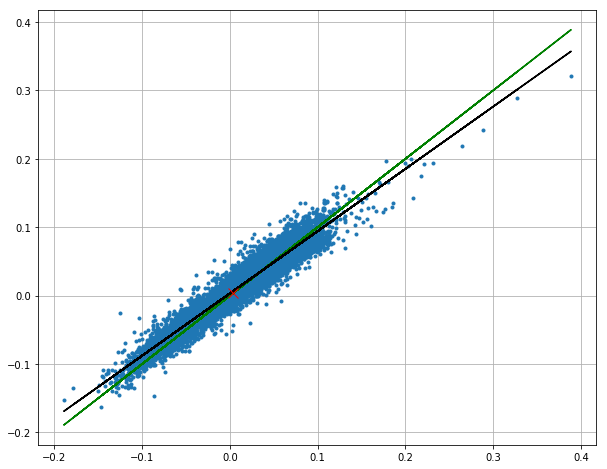

In [38]:
compare_pixels(maps5['A'], maps5['B'])

[ 0.91326132  0.00133197]


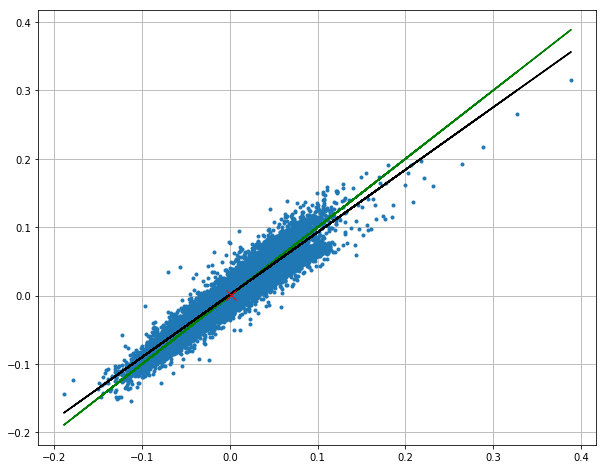

In [39]:
compare_pixels(maps5['A'], maps5['C'])

[ 0.99774198 -0.00180365]


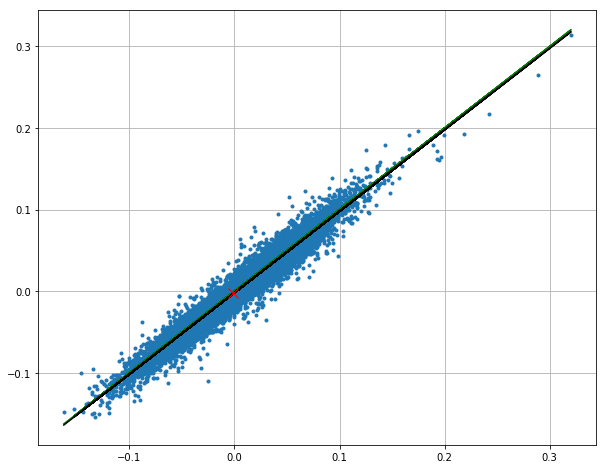

In [40]:
compare_pixels(maps5['B'], maps5['C'])

[ 0.83213499  0.0012823 ]


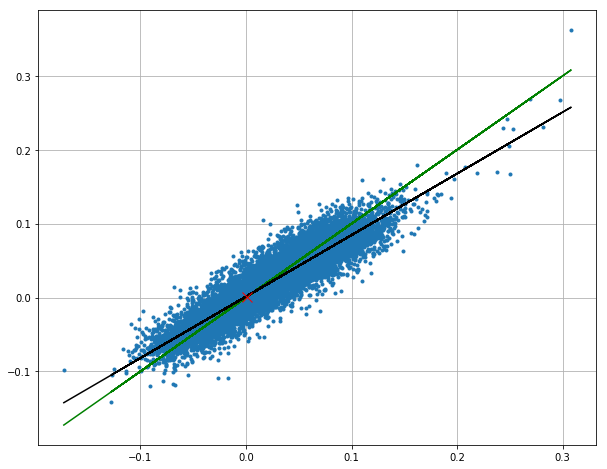

In [41]:
compare_pixels(maps2['A'], maps2['B'])

[ 0.82558036  0.00182638]


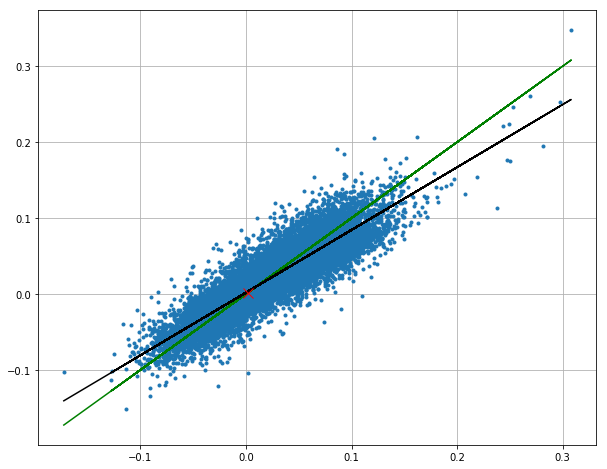

In [42]:
compare_pixels(maps2['A'], maps2['C'])

[ 0.95772614  0.00120457]


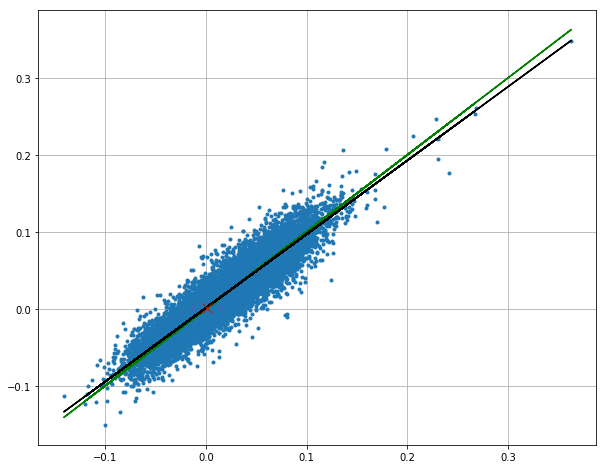

In [43]:
compare_pixels(maps2['B'], maps2['C'])

[  6.24594660e-01  -3.02599549e-04]


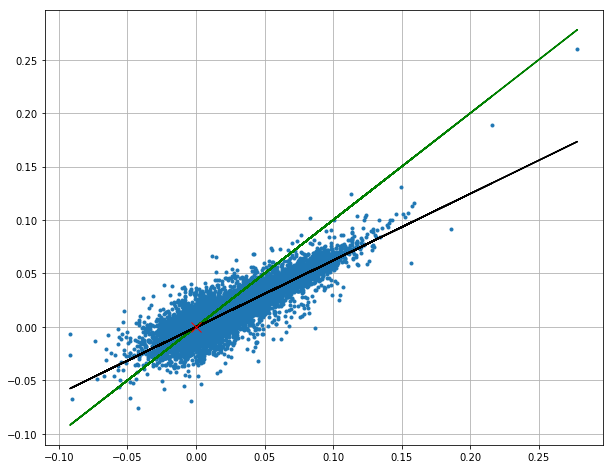

In [44]:
compare_pixels(maps3['A'], maps3['B'])

[ 0.55876144 -0.00092202]


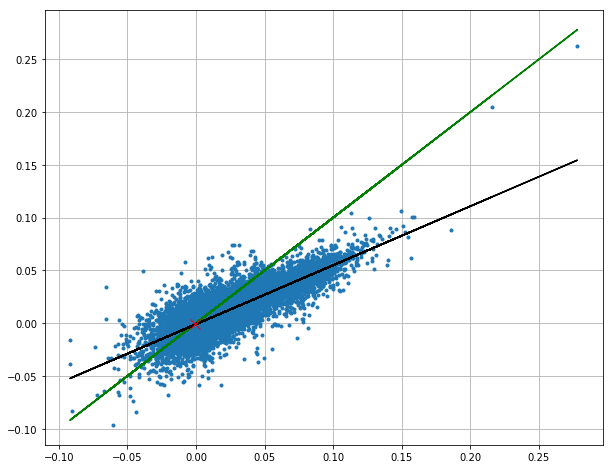

In [45]:
compare_pixels(maps3['A'], maps3['C'])

[  8.20864174e-01   1.74488119e-04]


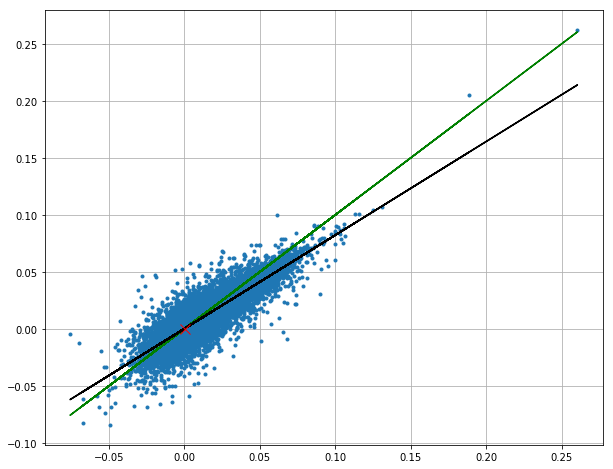

In [46]:
compare_pixels(maps3['B'], maps3['C'])

[ 0.44581388  0.01351088]


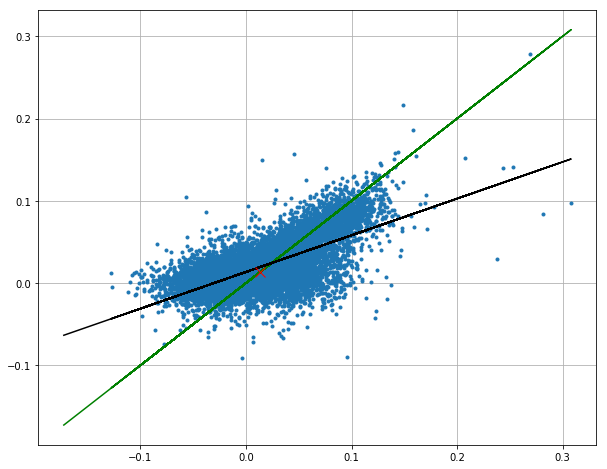

In [48]:
compare_pixels(maps2['A'], maps3['A'])

[ 0.85769073 -0.01460195]


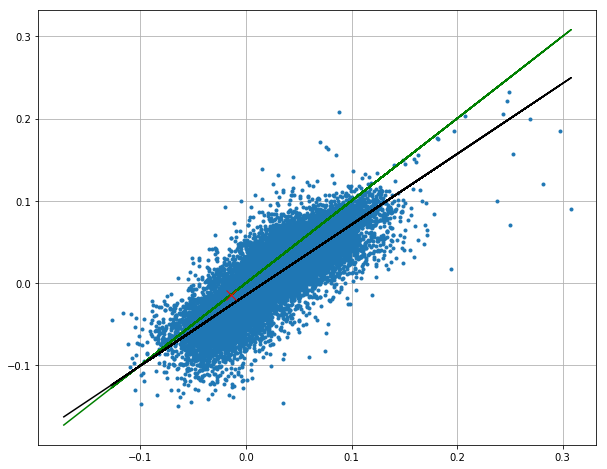

In [49]:
compare_pixels(maps2['A'], maps5['A'])

[ 0.99084102 -0.02296272]


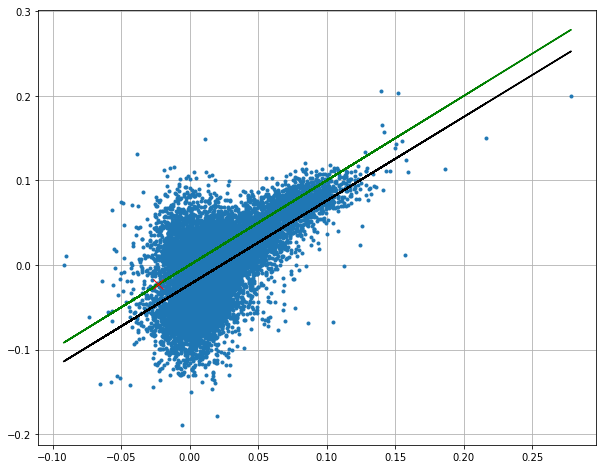

In [50]:
compare_pixels(maps3['A'], maps5['A'])

[ 0.27729366  0.00904127]


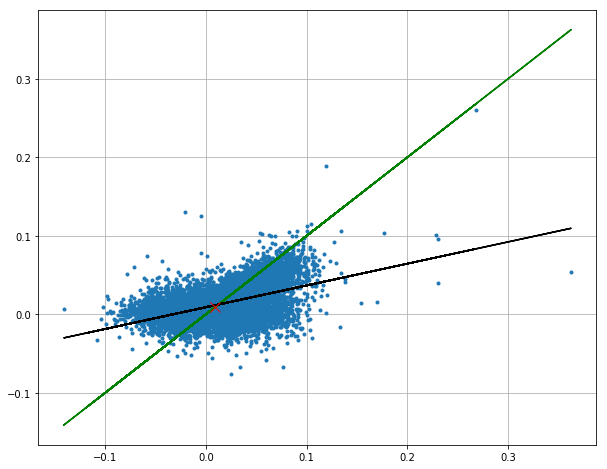

In [51]:
compare_pixels(maps2['B'], maps3['B'])

[ 0.90462619 -0.01143596]


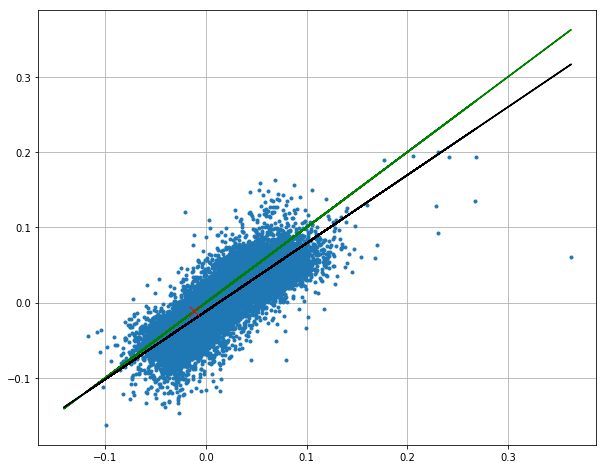

In [52]:
compare_pixels(maps2['B'], maps5['B'])

[ 0.83199786 -0.01228501]


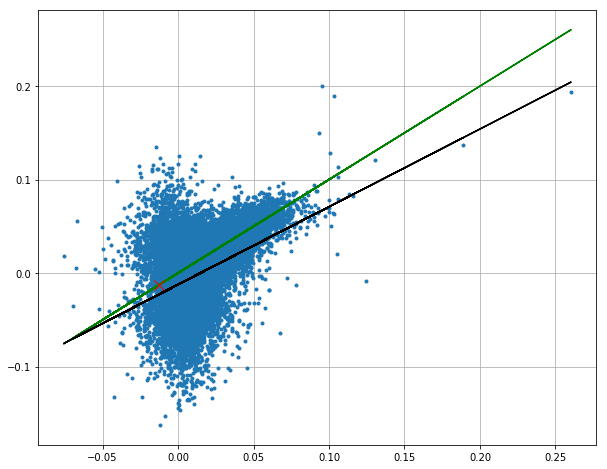

In [53]:
compare_pixels(maps3['B'], maps5['B'])

[ 0.18647799  0.00808354]


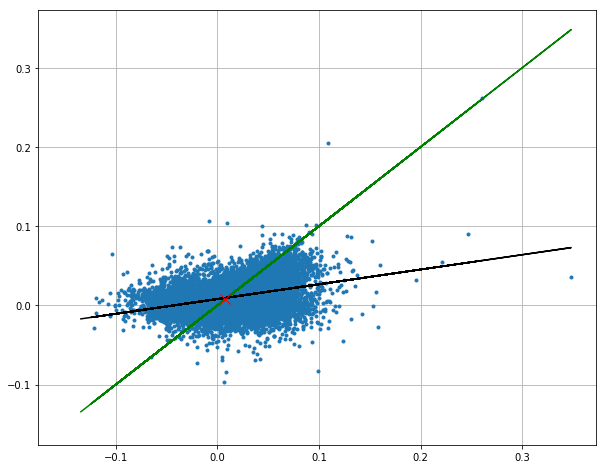

In [54]:
compare_pixels(maps2['C'], maps3['C'])

[ 0.85694204 -0.01289248]


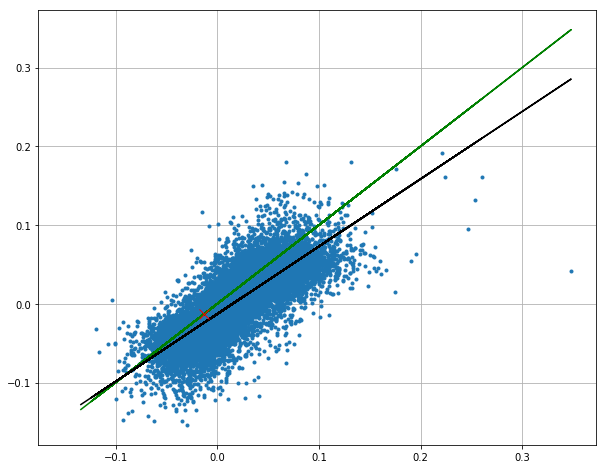

In [55]:
compare_pixels(maps2['C'], maps5['C'])

[ 0.59584451 -0.01039636]


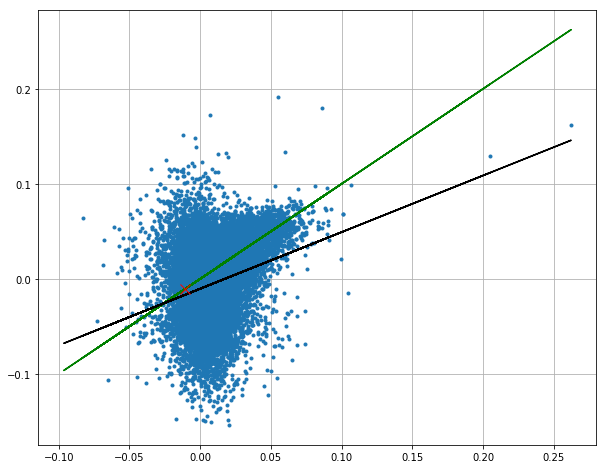

In [56]:
compare_pixels(maps3['C'], maps5['C'])

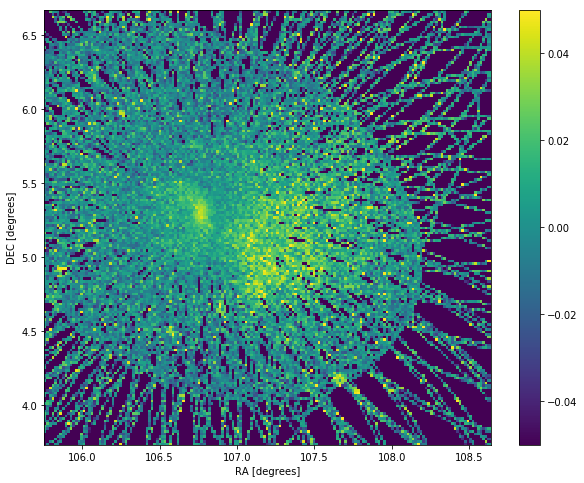

In [57]:
difference_map(maps2['A'], maps2['B'])

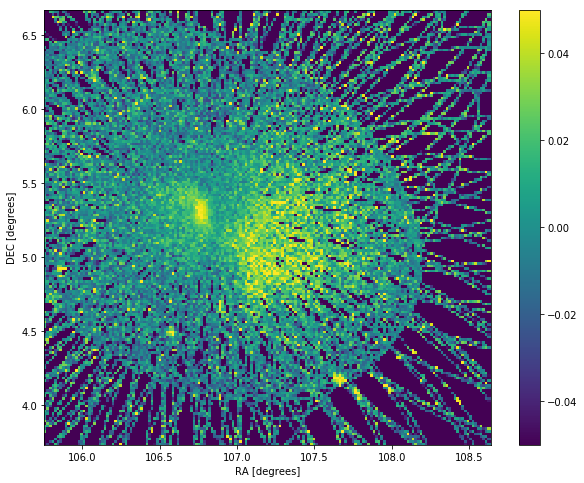

In [58]:
difference_map(maps2['A'], maps2['C'])

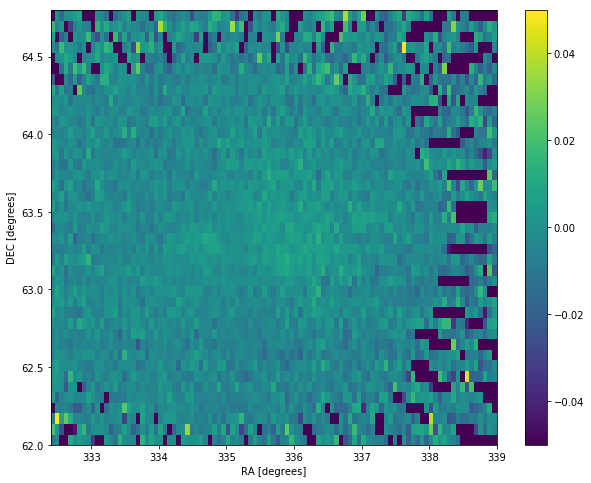

In [40]:
difference_map(maps2['B'], maps2['C'])

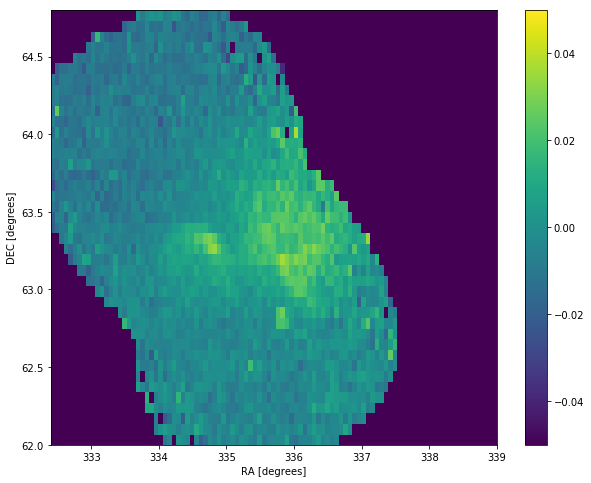

In [53]:
difference_map(maps3['A'], maps3['B'])

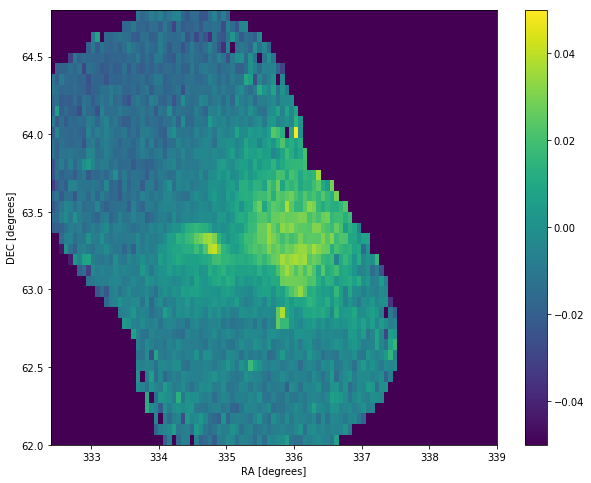

In [54]:
difference_map(maps3['A'], maps3['C'])

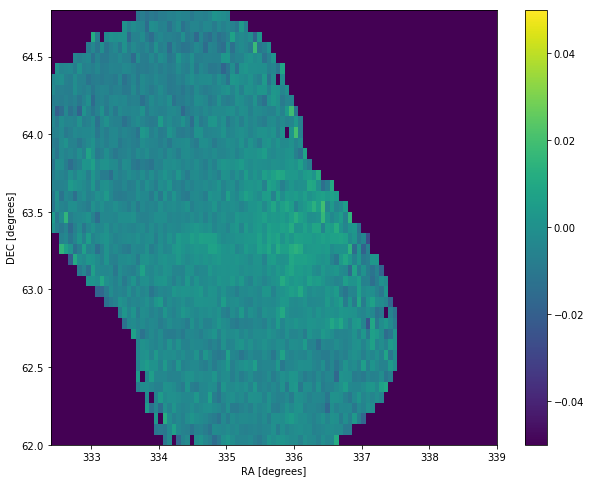

In [55]:
difference_map(maps3['B'], maps3['C'])

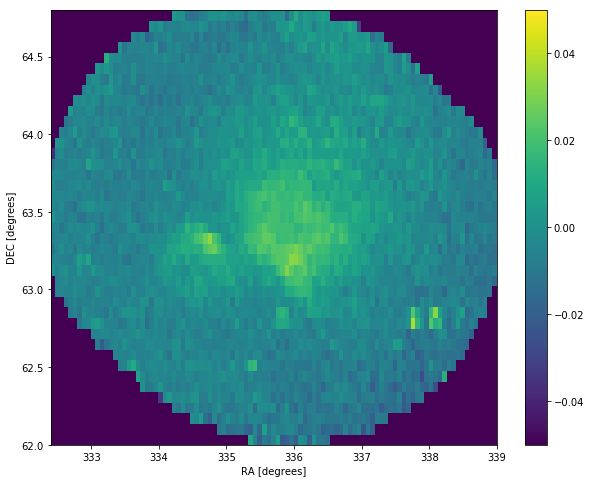

In [57]:
difference_map(maps5['A'], maps5['B'])

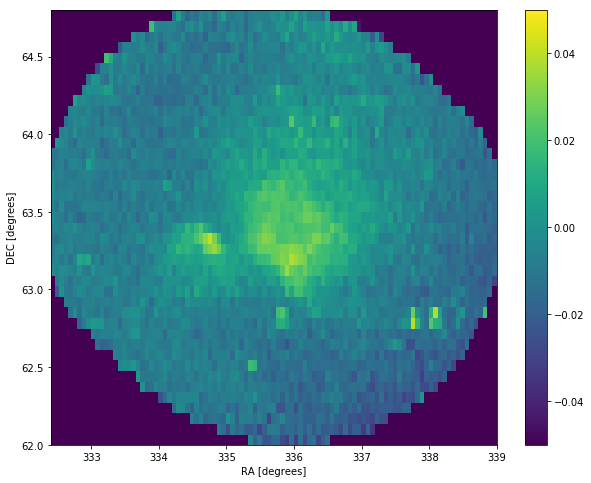

In [58]:
difference_map(maps5['A'], maps5['C'])

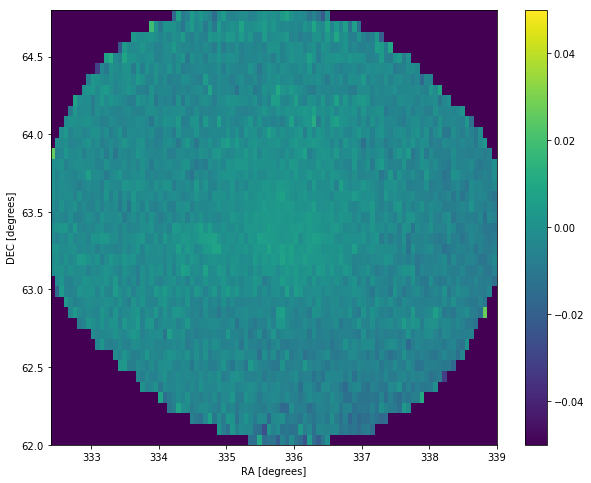

In [59]:
difference_map(maps5['B'], maps5['C'])

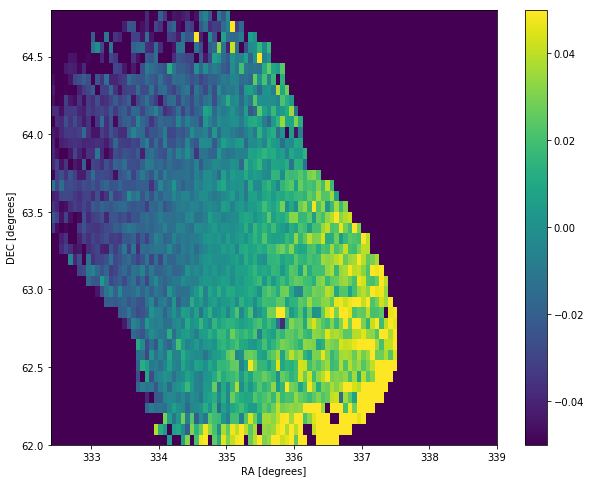

In [65]:
difference_map(maps2['A'], maps3['A'], True)

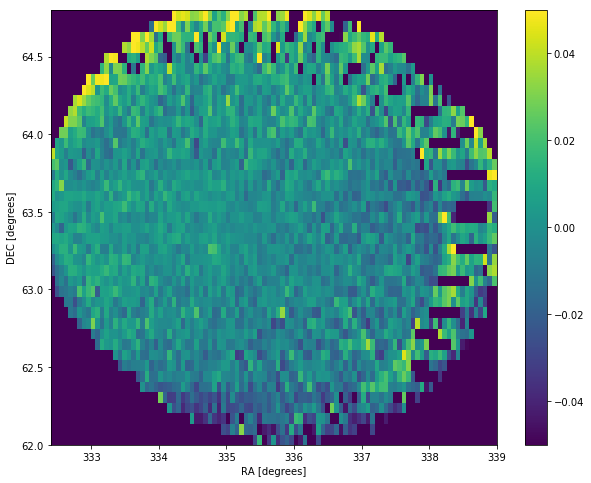

In [66]:
difference_map(maps2['A'], maps5['A'], True)

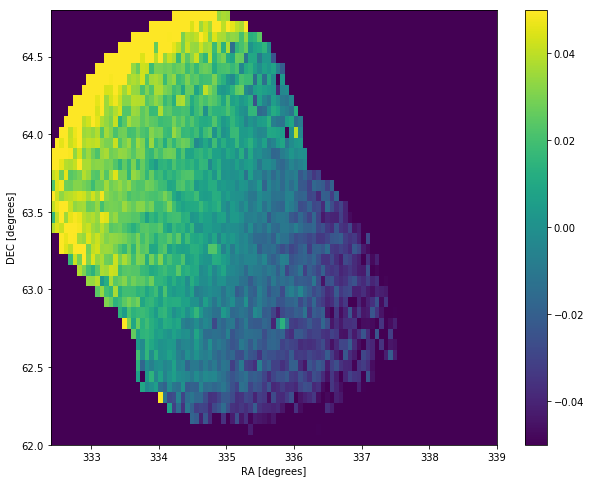

In [67]:
difference_map(maps3['A'], maps5['A'], True)

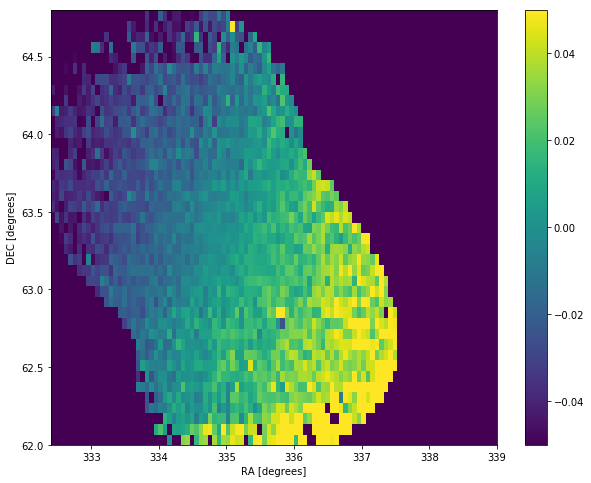

In [68]:
difference_map(maps2['B'], maps3['B'], True)

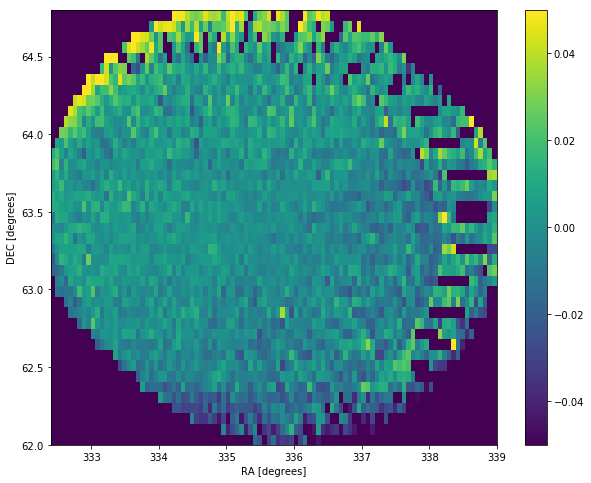

In [69]:
difference_map(maps2['B'], maps5['B'], True)

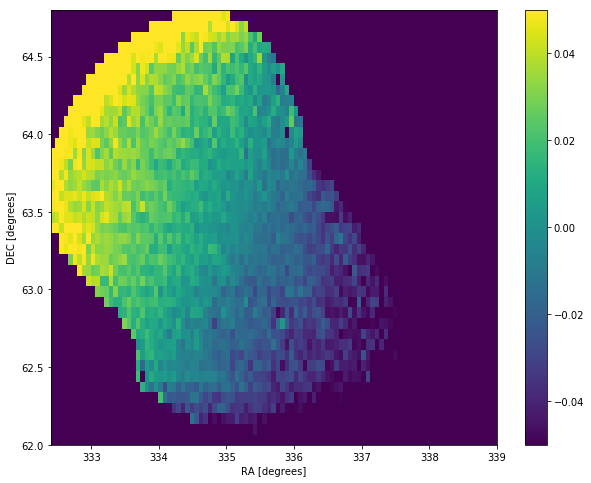

In [70]:
difference_map(maps3['B'], maps5['B'], True)

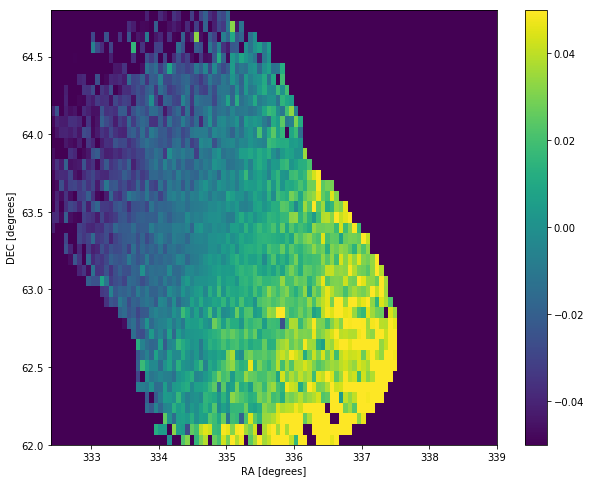

In [71]:
difference_map(maps2['C'], maps3['C'], True)

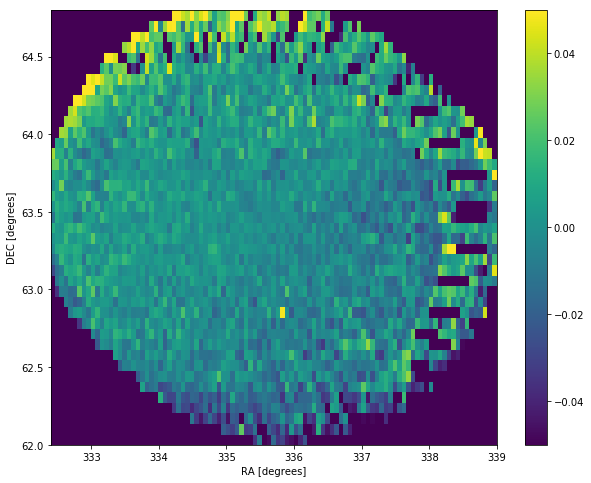

In [72]:
difference_map(maps2['C'], maps5['C'], True)

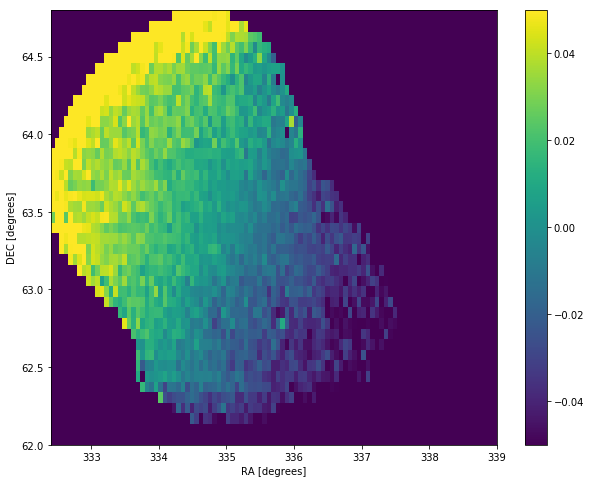

In [73]:
difference_map(maps3['C'], maps5['C'], True)